<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202402/blob/main/Lecture08/Notebook_Classification_ClassImbalance.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Classification

To work through the steps of probability-based classification, we’ll use a real dataset on unemployment from the Argentine Permanent Household Survey (EPH). This dataset includes socio-economic and demographic variables that allow us to predict whether a person is unemployed or not.

Unemployment prediction is a classic problem of classification and remains one of the key application areas for machine learning: we use previous employment results (employed versus unemployed) to train a model that can predict the employment status of individuals in new cases.

\begin{align}
Unemployment = f(x) + u
\end{align}

where $Unemployment = I(Unemployment=1)$


In [1]:
# install.packages("pacman") #run this line if you use Google Colab

In [2]:
#Cargar librerías 
require("pacman")
p_load("tidyverse", "caret", "glmnet","MLeval","MLmetrics")
set.seed(1011)

Loading required package: pacman



In [3]:
#Leer los datos 
db <- readRDS(url("https://github.com/ignaciomsarmiento/datasets/blob/main/desempelo_arg_2010.Rds?raw=true"))
db <- db %>% filter(ciudad%in%c("Partidos del GBA", "Ciudad de Buenos Aires"))
head(db)

desempleado,edad,mujer,parentesco,nivel_ed,estado_civil,total_miembros_hogar,miembros_hogar_menores10,ing_tot_fam,tipo_vivienda,ciudad,trimestre,id_hogar
<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<chr>
0,31,0,Jefe/a,Superior Universitaria Incompleta,Unido/a,3,1,8400,Casa,Partidos del GBA,1,1251051
0,33,1,Conyuge/Pareja,Superior Universitaria Completa,Unido/a,3,1,8400,Casa,Partidos del GBA,1,1251051
0,48,0,Jefe/a,Primaria Completa,Casado/a,3,0,3150,Casa,Partidos del GBA,1,1251801
0,46,1,Conyuge/Pareja,Secundaria Incompleta,Casado/a,3,0,3150,Casa,Partidos del GBA,1,1251801
0,63,0,Jefe/a,Superior Universitaria Incompleta,Casado/a,2,0,3550,Casa,Partidos del GBA,1,1253471
0,50,0,Jefe/a,Superior Universitaria Completa,Casado/a,3,0,3500,Casa,Partidos del GBA,1,1254331


In [4]:
table(db$nivel_ed)


Primaria Incompleta (incluye educación especial) 
                                             510 
                               Primaria Completa 
                                            2203 
                           Secundaria Incompleta 
                                            2053 
                             Secundaria Completa 
                                            2985 
               Superior Universitaria Incompleta 
                                            1816 
                 Superior Universitaria Completa 
                                            2460 
                                 Sin instrucción 
                                              27 
                                         Ns./Nr. 
                                               0 

In [5]:
#db <- db %>% filter(nivel_ed!="Ns./Nr.")
db$nivel_ed <- droplevels(db$nivel_ed)
table(db$nivel_ed)


Primaria Incompleta (incluye educación especial) 
                                             510 
                               Primaria Completa 
                                            2203 
                           Secundaria Incompleta 
                                            2053 
                             Secundaria Completa 
                                            2985 
               Superior Universitaria Incompleta 
                                            1816 
                 Superior Universitaria Completa 
                                            2460 
                                 Sin instrucción 
                                              27 

In [6]:
db$tipo_vivienda <- droplevels(db$tipo_vivienda)
db$parentesco <- droplevels(db$parentesco)

In [7]:
table(db$tipo_vivienda)


                               Casa                        Departamento 
                               7888                                4084 
                 Pieza de inquilino              Pieza en hotel/pension 
                                 53                                   8 
Local no construido para habitacion                               Otros 
                                  2                                  19 

In [8]:
db <- db %>% mutate(tipo_vivienda=recode(tipo_vivienda,
                                         "Pieza de inquilino"="Otros",
                                         "Pieza en hotel/pension"="Otros",
                                         "Local no construido para habitacion"="Otros"))
table(db$tipo_vivienda)                  


        Casa Departamento        Otros 
        7888         4084           82 

In [9]:
db <- db %>% mutate(mujer=factor(mujer,levels=c(0,1),labels=c("hombre","mujer")))
head(db)

desempleado,edad,mujer,parentesco,nivel_ed,estado_civil,total_miembros_hogar,miembros_hogar_menores10,ing_tot_fam,tipo_vivienda,ciudad,trimestre,id_hogar
<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<chr>
0,31,hombre,Jefe/a,Superior Universitaria Incompleta,Unido/a,3,1,8400,Casa,Partidos del GBA,1,1251051
0,33,mujer,Conyuge/Pareja,Superior Universitaria Completa,Unido/a,3,1,8400,Casa,Partidos del GBA,1,1251051
0,48,hombre,Jefe/a,Primaria Completa,Casado/a,3,0,3150,Casa,Partidos del GBA,1,1251801
0,46,mujer,Conyuge/Pareja,Secundaria Incompleta,Casado/a,3,0,3150,Casa,Partidos del GBA,1,1251801
0,63,hombre,Jefe/a,Superior Universitaria Incompleta,Casado/a,2,0,3550,Casa,Partidos del GBA,1,1253471
0,50,hombre,Jefe/a,Superior Universitaria Completa,Casado/a,3,0,3500,Casa,Partidos del GBA,1,1254331


In [10]:
prop.table(table(db$desempleado))*100


        0         1 
91.538079  8.461921 

In [11]:
data<- db  %>% group_by(desempleado) %>% tally() 
data <- data %>% mutate(n=n/sum(n))                        

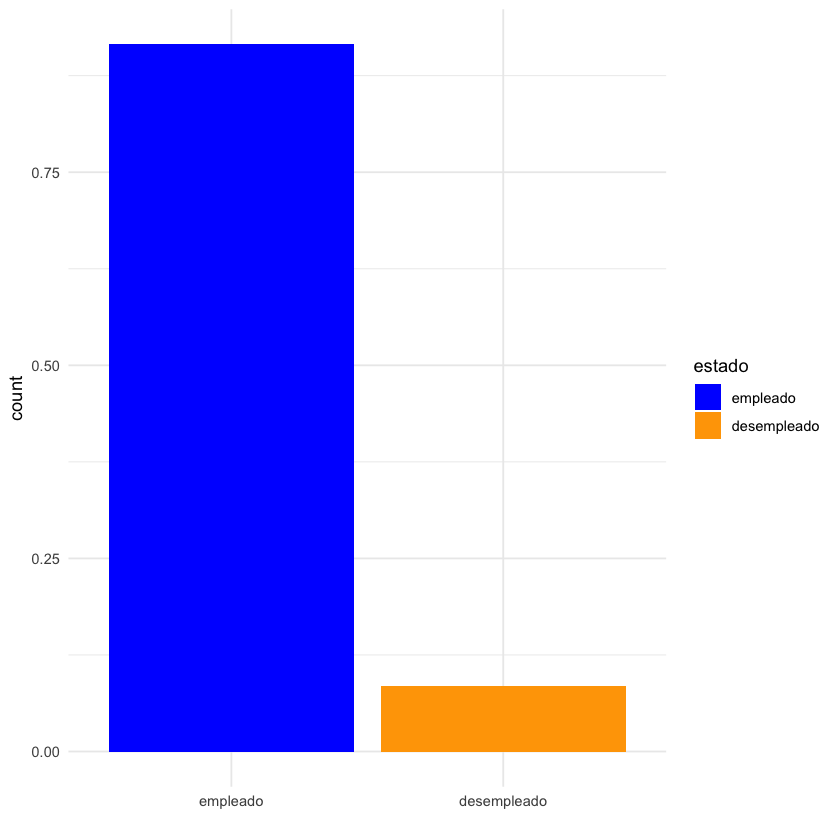

In [12]:
data<-  data %>% mutate(estado =factor(desempleado, levels = c(0,1), labels = c("empleado","desempleado")) )

ggplot(data,aes(x = estado, y = n, fill = estado)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  scale_fill_manual(values = c("desempleado" = "orange", "empleado"= "blue")) + # Colors can be changed
  labs(x = "", y = "count") # Customize axis labels if needed



If you have an imbalanced data set, first try training on the true distribution. If the model works well and generalizes, you're done! If not, try  the remedies listed below.

## Estimación Logit

\begin{align}
p_i &=\frac{e^{X_i\beta}}{1+e^{X_i\beta}}
\end{align}


In [13]:
mylogit <- glm(desempleado~edad+mujer, data = db, family = "binomial")
summary(mylogit,type="text")


Call:
glm(formula = desempleado ~ edad + mujer, family = "binomial", 
    data = db)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.060631   0.106220  -9.985  < 2e-16 ***
edad        -0.043359   0.002896 -14.971  < 2e-16 ***
mujermujer   0.467160   0.066421   7.033 2.02e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6989.1  on 12053  degrees of freedom
Residual deviance: 6691.8  on 12051  degrees of freedom
AIC: 6697.8

Number of Fisher Scoring iterations: 5


## Prediction


\begin{align}
\hat{p}_i &=\frac{e^{X_i\hat{\beta}}}{1+e^{X_i\hat{\beta}}}
\end{align}

In [14]:

db<- db  %>% mutate(prob_hat=predict(mylogit,newdata = db, type = "response")) #type = "response" gives the predicted probabilities.

head(db  %>% select(desempleado,prob_hat))


desempleado,prob_hat
<dbl>,<dbl>
0,0.08280964
0,0.11667205
0,0.04141245
0,0.06991466
0,0.02204733
0,0.03810359


## Classification 

\begin{align}
\hat{Y}_i= 1[\hat{p}_i >0.5]
\end{align}

In [15]:
rule <- 1/2 # Bayes Rule

db <-  db  %>% mutate(desempleado_hat=ifelse(prob_hat>rule,1,0))    ## predicted class labels

head(db  %>% select(desempleado,prob_hat,desempleado_hat))


desempleado,prob_hat,desempleado_hat
<dbl>,<dbl>,<dbl>
0,0.08280964,0
0,0.11667205,0
0,0.04141245,0
0,0.06991466,0
0,0.02204733,0
0,0.03810359,0


## Out of sample prediction

In [16]:
p_load("caret")


inTrain <- createDataPartition(
  y = db$desempleado, ## La variable dependiente u objetivo 
  p = .7,  ## Usamos 70%  de los datos en el conjunto de entrenamiento 
  list = FALSE)


train <- db[ inTrain,]
test  <- db[-inTrain,]

In [17]:
head(train)

desempleado,edad,mujer,parentesco,nivel_ed,estado_civil,total_miembros_hogar,miembros_hogar_menores10,ing_tot_fam,tipo_vivienda,ciudad,trimestre,id_hogar,prob_hat,desempleado_hat
<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>
0,33,mujer,Conyuge/Pareja,Superior Universitaria Completa,Unido/a,3,1,8400,Casa,Partidos del GBA,1,1251051,0.11667205,0
0,48,hombre,Jefe/a,Primaria Completa,Casado/a,3,0,3150,Casa,Partidos del GBA,1,1251801,0.04141245,0
0,63,hombre,Jefe/a,Superior Universitaria Incompleta,Casado/a,2,0,3550,Casa,Partidos del GBA,1,1253471,0.02204733,0
0,50,hombre,Jefe/a,Superior Universitaria Completa,Casado/a,3,0,3500,Casa,Partidos del GBA,1,1254331,0.03810359,0
0,23,hombre,Hijo/a - Hijastro/a,Superior Universitaria Incompleta,Soltero/a,3,0,3500,Casa,Partidos del GBA,1,1254331,0.11325698,0
0,32,mujer,Jefe/a,Superior Universitaria Completa,Soltero/a,1,0,3870,Departamento,Ciudad de Buenos Aires,1,1256841,0.12121546,0


In [18]:
prop.table(table(train$desempleado))


         0          1 
0.91739749 0.08260251 

In [19]:
prop.table(table(test$desempleado))


         0          1 
0.91067478 0.08932522 

### Logit

In [20]:
ctrl<- trainControl(method = "cv",
                    number = 5,
                    classProbs = TRUE,
                    verbose=FALSE,
                    savePredictions = T)


In [21]:
train<- train %>% mutate(desempleado_num =desempleado)

# # Clace que "desempleado" sea el primer nivel!!
train<- train %>% mutate(desempleado = factor(desempleado, levels = c(1,0), labels = c("desempleado","empleado")))
test<- test %>% mutate(desempleado = factor(desempleado, levels = c(1,0), labels = c("desempleado","empleado")))


In [22]:
prop.table(table(train$desempleado))


desempleado    empleado 
 0.08260251  0.91739749 

In [23]:
set.seed(1410)
mylogit_caret <- train(desempleado~edad+mujer+nivel_ed+ parentesco +
                        estado_civil+tipo_vivienda+ing_tot_fam+total_miembros_hogar+miembros_hogar_menores10,
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial")


mylogit_caret

Generalized Linear Model 

8438 samples
   9 predictor
   2 classes: 'desempleado', 'empleado' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 6750, 6751, 6750, 6751, 6750 
Resampling results:

  Accuracy   Kappa     
  0.9170419  0.01105016


In [24]:
predictTest_logit <- data.frame(
  obs = test$desempleado,                                    ## observed class labels
  predict(mylogit_caret, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(mylogit_caret, newdata = test, type = "raw")    ## predicted class labels
)


In [25]:
head(predictTest_logit)

,obs,desempleado,empleado,pred
,<fct>,<dbl>,<dbl>,<fct>
1,empleado,0.01478977,0.9852102,empleado
2,empleado,0.13586405,0.8641359,empleado
3,empleado,0.01411712,0.9858829,empleado
4,empleado,0.05906118,0.9409388,empleado
5,empleado,0.08834240,0.9116576,empleado
6,empleado,0.11770076,0.8822992,empleado


In [26]:
test<- test  %>% mutate(desempleo_hat_logit_orig=predict(mylogit_caret,newdata = test,
                           type = "raw"))

In [27]:
confusionMatrix(data = test$desempleo_hat_logit_orig, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")


Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado           2        2
  empleado            321     3291
                                          
               Accuracy : 0.9107          
                 95% CI : (0.9009, 0.9198)
    No Information Rate : 0.9107          
    P-Value [Acc > NIR] : 0.5148          
                                          
                  Kappa : 0.0101          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.5000000       
                 Recall : 0.0061920       
                     F1 : 0.0122324       
             Prevalence : 0.0893252       
         Detection Rate : 0.0005531       
   Detection Prevalence : 0.0011062       
      Balanced Accuracy : 0.5027923       
                                          
       'Positive' Class : desempleado     
                      

In [28]:
X <- c("poly(edad,2,raw=TRUE)", "nivel_ed","mujer", 
        "parentesco", "estado_civil", 
        "tipo_vivienda",
        "poly(total_miembros_hogar,2,raw=TRUE)",
        "poly(miembros_hogar_menores10,2,raw=TRUE)",
        "poly(ing_tot_fam,2,raw=TRUE)")


set.seed(1410)
glm_model_logit_ampliado <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glm",
    data = train,
    family = "binomial",
    trControl = ctrl,
    preProcess = c("center", "scale")
  )



test<- test  %>% mutate(desempleo_hat_logit_ampliado=predict(glm_model_logit_ampliado,newdata = test,
                           type = "raw"))
confusionMatrix(data = test$desempleo_hat_logit_ampliado, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")


Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado          11        6
  empleado            312     3287
                                          
               Accuracy : 0.9121          
                 95% CI : (0.9024, 0.9211)
    No Information Rate : 0.9107          
    P-Value [Acc > NIR] : 0.3994          
                                          
                  Kappa : 0.0563          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.647059        
                 Recall : 0.034056        
                     F1 : 0.064706        
             Prevalence : 0.089325        
         Detection Rate : 0.003042        
   Detection Prevalence : 0.004701        
      Balanced Accuracy : 0.516117        
                                          
       'Positive' Class : desempleado     
                      

# ROC

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Not averaging probs.

Group 1 type: cv

Group 2 type: cv

Observations: 16876

Number of groups: 2

Observations per group: 8438

Positive: empleado

Negative: desempleado

Group: Basic

Positive: 7741

Negative: 697

Group: Ampliado

Positive: 7741

Negative: 697

***Performance Metrics***

Basic Optimal Informedness = 0.367468158978344

Ampliado Optimal Informedness = 0.382267035889505

Basic AUC-ROC = 0.75

Ampliado AUC-ROC = 0.76



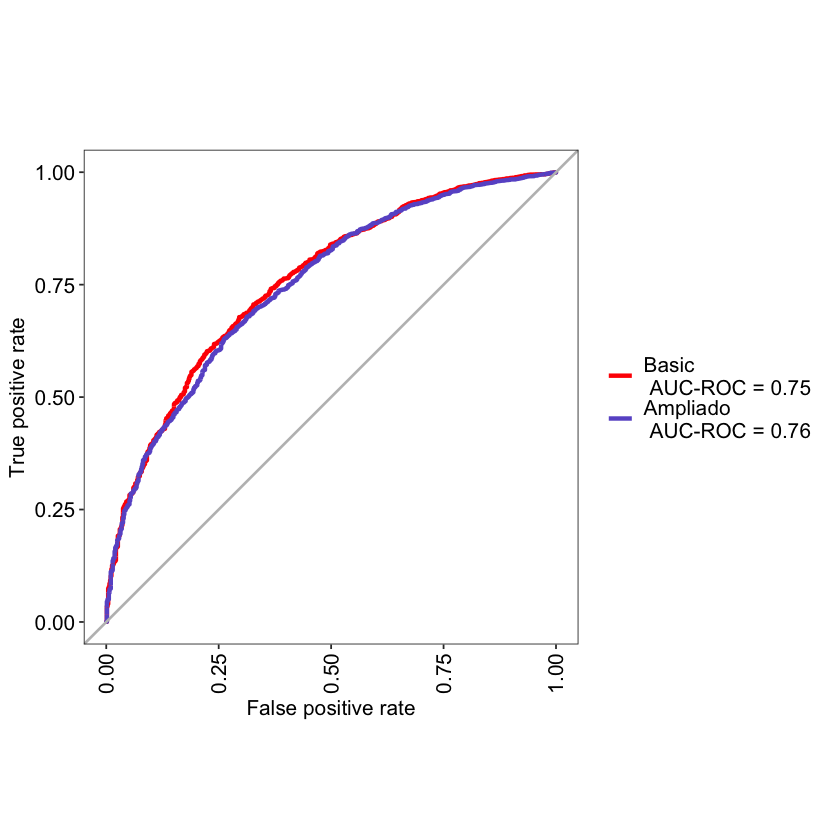

In [29]:
#Curva ROC
res_insample_all <- evalm(list(mylogit_caret, glm_model_logit_ampliado),gnames=c('Basic','Ampliado'),plots='r')

In [30]:
X <- c("poly(edad,2,raw=TRUE)", "nivel_ed","mujer", 
        "parentesco", "estado_civil", 
        "tipo_vivienda*poly(total_miembros_hogar,2,raw=TRUE)", #cambio
        "poly(total_miembros_hogar,2,raw=TRUE)",
        "poly(miembros_hogar_menores10,2,raw=TRUE)",
        "poly(ing_tot_fam,2,raw=TRUE)")


lambda <- 10^seq(-1, -4, length = 50)
grid <- expand.grid("alpha" = seq(0,1,by=.1), lambda = lambda)

set.seed(1410)
glm_model_en <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glmnet",
    data = train,
    family = "binomial",
    trControl = ctrl,
    tuneGrid = grid,
    preProcess = c("center", "scale")
  )

glm_model_en



glmnet 

8438 samples
   9 predictor
   2 classes: 'desempleado', 'empleado' 

Pre-processing: centered (34), scaled (34) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 6750, 6751, 6750, 6751, 6750 
Resampling results across tuning parameters:

  alpha  lambda        Accuracy   Kappa        
  0.0    0.0001000000  0.9170421   0.0039988742
  0.0    0.0001151395  0.9170421   0.0039988742
  0.0    0.0001325711  0.9170421   0.0039988742
  0.0    0.0001526418  0.9170421   0.0039988742
  0.0    0.0001757511  0.9170421   0.0039988742
  0.0    0.0002023590  0.9170421   0.0039988742
  0.0    0.0002329952  0.9170421   0.0039988742
  0.0    0.0002682696  0.9170421   0.0039988742
  0.0    0.0003088844  0.9170421   0.0039988742
  0.0    0.0003556480  0.9170421   0.0039988742
  0.0    0.0004094915  0.9170421   0.0039988742
  0.0    0.0004714866  0.9170421   0.0039988742
  0.0    0.0005428675  0.9170421   0.0039988742
  0.0    0.0006250552  0.9170421   0.0039988742
  0.0    0.0007196

In [31]:
test<- test  %>% mutate(desempleo_hat_logit_en=predict(glm_model_en,newdata = test,
                           type = "raw"))
confusionMatrix(data = test$desempleo_hat_logit_en, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado           0        0
  empleado            323     3293
                                          
               Accuracy : 0.9107          
                 95% CI : (0.9009, 0.9198)
    No Information Rate : 0.9107          
    P-Value [Acc > NIR] : 0.5148          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision :      NA         
                 Recall : 0.00000         
                     F1 :      NA         
             Prevalence : 0.08933         
         Detection Rate : 0.00000         
   Detection Prevalence : 0.00000         
      Balanced Accuracy : 0.50000         
                                          
       'Positive' Class : desempleado     
                      

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Not averaging probs.

Group 1 type: cv

Group 2 type: cv

Group 3 type: cv

Observations: 25314

Number of groups: 3

Observations per group: 8438

Positive: empleado

Negative: desempleado

Group: Basic

Positive: 7741

Negative: 697

Group: Ampliado

Positive: 7741

Negative: 697

Group: EN

Positive: 7741

Negative: 697

***Performance Metrics***

Basic Optimal Informedness = 0.367468158978344

Ampliado Optimal Informedness = 0.382267035889505

EN Optimal Informedness = 0.3472679060628

Basic AUC-ROC = 0.75

Ampliado AUC-ROC = 0.76

EN AUC-ROC = 0.72



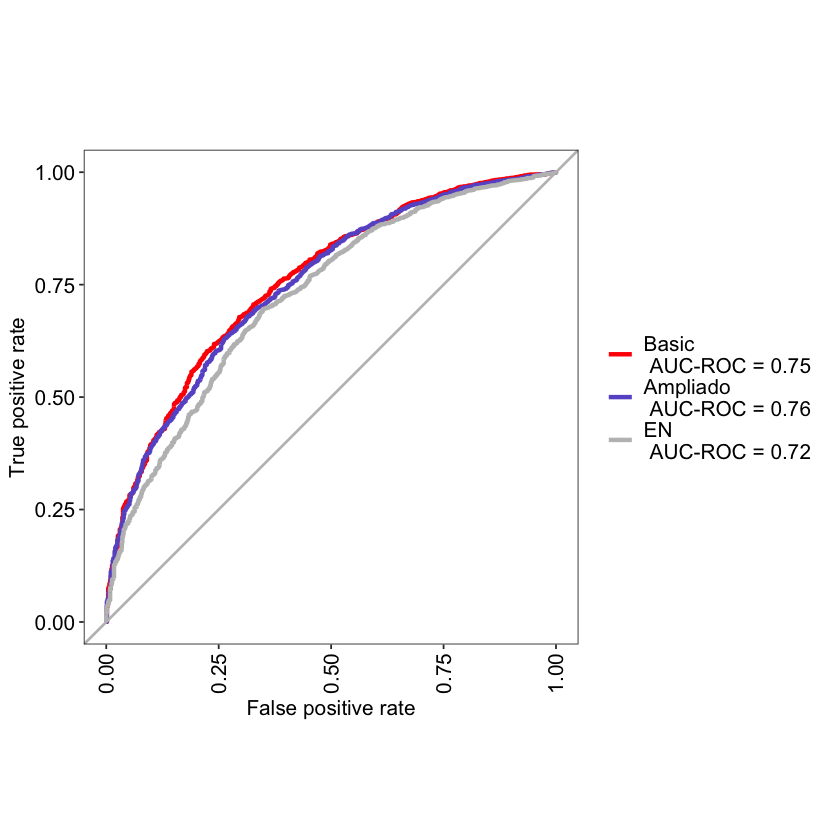

In [32]:
#Curva ROC
res_insample_all <- evalm(list(mylogit_caret, glm_model_logit_ampliado,glm_model_en),gnames=c('Basic','Ampliado','EN'),plots='r')

# Class Imbalance: Remedies

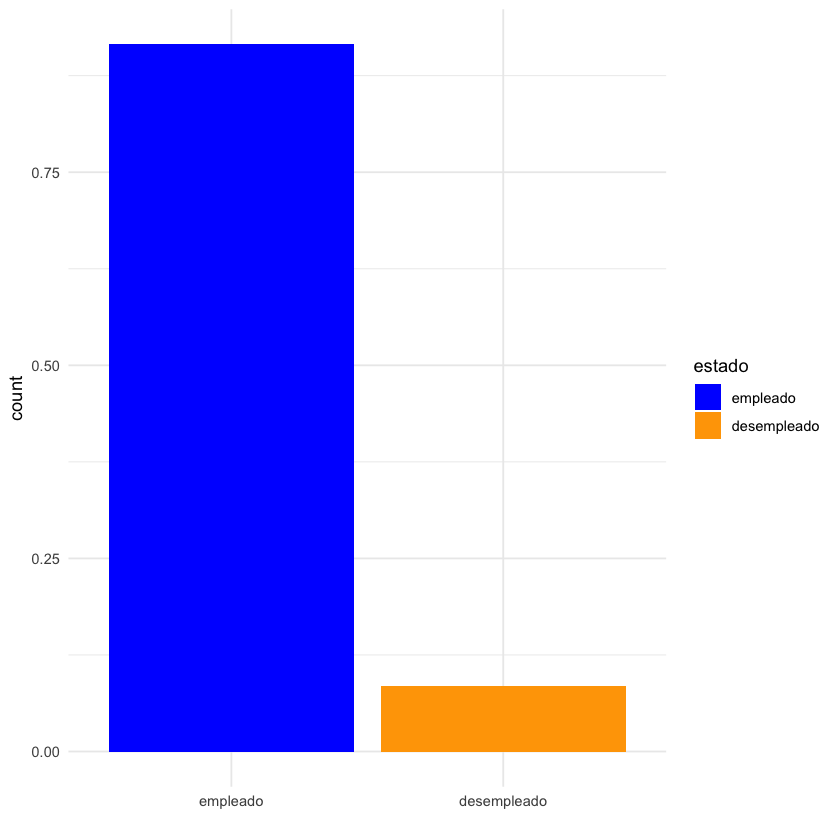

In [33]:

ggplot(data,aes(x = estado, y = n, fill = estado)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  scale_fill_manual(values = c("desempleado" = "orange", "empleado"= "blue")) + # Colors can be changed
  labs(x = "", y = "count") # Customize axis labels if needed



## Model Tuning

The simplest approach to counteracting the negative eﬀects of class imbalance is to tune the model to maximize the accuracy of the minority class(es).

In [35]:
multiStats <- function(...) c(twoClassSummary(...), defaultSummary(...), prSummary(...))

ctrl_multiStats<- trainControl(method = "cv",
                     number = 5,
                     summaryFunction = multiStats,
                     classProbs = TRUE,
                     verbose=FALSE,
                     savePredictions = T)

In [36]:

X <- c("poly(edad,2,raw=TRUE)", "nivel_ed","mujer", 
        "parentesco", "estado_civil", 
        "tipo_vivienda*poly(total_miembros_hogar,2,raw=TRUE)", #cambio
        "poly(total_miembros_hogar,2,raw=TRUE)",
        "poly(miembros_hogar_menores10,2,raw=TRUE)",
        "poly(ing_tot_fam,2,raw=TRUE)")


lambda <- 10^seq(-1, -4, length = 50)
grid <- expand.grid("alpha" = seq(0,1,by=.2), lambda = lambda)

set.seed(1410)
glm_model_en_sens <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glmnet",
    data = train,
    family = "binomial",
    tuneGrid = grid,
    preProcess = c("center", "scale"),
    trControl = ctrl_multiStats,
    metric = "Sens"
  )

glm_model_en_sens

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


glmnet 

8438 samples
   9 predictor
   2 classes: 'desempleado', 'empleado' 

Pre-processing: centered (34), scaled (34) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 6750, 6751, 6750, 6751, 6750 
Resampling results across tuning parameters:

  alpha  lambda        ROC        Sens         Spec       Accuracy 
  0.0    0.0001000000  0.7504204  0.002867420  0.9993540  0.9170421
  0.0    0.0001151395  0.7504204  0.002867420  0.9993540  0.9170421
  0.0    0.0001325711  0.7504204  0.002867420  0.9993540  0.9170421
  0.0    0.0001526418  0.7504204  0.002867420  0.9993540  0.9170421
  0.0    0.0001757511  0.7504204  0.002867420  0.9993540  0.9170421
  0.0    0.0002023590  0.7504204  0.002867420  0.9993540  0.9170421
  0.0    0.0002329952  0.7504204  0.002867420  0.9993540  0.9170421
  0.0    0.0002682696  0.7504204  0.002867420  0.9993540  0.9170421
  0.0    0.0003088844  0.7504204  0.002867420  0.9993540  0.9170421
  0.0    0.0003556480  0.7504204  0.002867420  0.9993540  

In [37]:
test<- test  %>% mutate(desempleo_hat_logit_en_sens=predict(glm_model_en_sens,newdata = test,
                           type = "raw"))
confusionMatrix(data = test$desempleo_hat_logit_en_sens, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado           9        3
  empleado            314     3290
                                          
               Accuracy : 0.9123          
                 95% CI : (0.9026, 0.9214)
    No Information Rate : 0.9107          
    P-Value [Acc > NIR] : 0.377           
                                          
                  Kappa : 0.0476          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.750000        
                 Recall : 0.027864        
                     F1 : 0.053731        
             Prevalence : 0.089325        
         Detection Rate : 0.002489        
   Detection Prevalence : 0.003319        
      Balanced Accuracy : 0.513476        
                                          
       'Positive' Class : desempleado     
                      

## Alternative Cutoﬀs

When there are two possible outcome categories, another method for increasing the prediction accuracy of the minority class samples is to determine alternative cutoﬀs for the predicted probabilities which eﬀectively changes the definition of a predicted event.

In [38]:
p_load("pROC")

roc_obj_en<-roc(response=glm_model_en_sens$pred$obs[glm_model_en_sens$pred$lambda==glm_model_en_sens$bestTune$lambda],
                   predictor=glm_model_en_sens$pred$desempleado[glm_model_en_sens$pred$lambda==glm_model_en_sens$bestTune$lambda],
                  levels = c("empleado", "desempleado"),  # Establecer control y caso
                  direction = "<")  # "<" significa que "desempleado" es positivo

In [40]:
roc_obj_en


Call:
roc.default(response = glm_model_en_sens$pred$obs[glm_model_en_sens$pred$lambda ==     glm_model_en_sens$bestTune$lambda], predictor = glm_model_en_sens$pred$desempleado[glm_model_en_sens$pred$lambda ==     glm_model_en_sens$bestTune$lambda], levels = c("empleado",     "desempleado"), direction = "<")

Data: glm_model_en_sens$pred$desempleado[glm_model_en_sens$pred$lambda == glm_model_en_sens$bestTune$lambda] in 46446 controls (glm_model_en_sens$pred$obs[glm_model_en_sens$pred$lambda == glm_model_en_sens$bestTune$lambda] empleado) < 4182 cases (glm_model_en_sens$pred$obs[glm_model_en_sens$pred$lambda == glm_model_en_sens$bestTune$lambda] desempleado).
Area under the curve: 0.7563

In [41]:
rfThresh_en <- coords(roc_obj_en, x = "best", best.method = "closest.topleft")
rfThresh_en

threshold,specificity,sensitivity
<dbl>,<dbl>,<dbl>
0.07892149,0.6700039,0.7042085


In [42]:

test<- test  %>% mutate(desempleo_prob_logit_en_sens=predict(glm_model_en_sens,newdata = test,
                           type = "prob")$desempleado)
head(test)

desempleado,edad,mujer,parentesco,nivel_ed,estado_civil,total_miembros_hogar,miembros_hogar_menores10,ing_tot_fam,tipo_vivienda,ciudad,trimestre,id_hogar,prob_hat,desempleado_hat,desempleo_hat_logit_orig,desempleo_hat_logit_ampliado,desempleo_hat_logit_en,desempleo_hat_logit_en_sens,desempleo_prob_logit_en_sens
<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>
empleado,31,hombre,Jefe/a,Superior Universitaria Incompleta,Unido/a,3,1,8400,Casa,Partidos del GBA,1,1251051,0.08280964,0,empleado,empleado,empleado,empleado,0.01267673
empleado,46,mujer,Conyuge/Pareja,Secundaria Incompleta,Casado/a,3,0,3150,Casa,Partidos del GBA,1,1251801,0.06991466,0,empleado,empleado,empleado,empleado,0.10879730
empleado,46,hombre,Jefe/a,Primaria Completa,Casado/a,4,2,5500,Casa,Partidos del GBA,1,1260111,0.04499519,0,empleado,empleado,empleado,empleado,0.01252388
empleado,36,mujer,Conyuge/Pareja,Secundaria Incompleta,Casado/a,4,2,5500,Casa,Partidos del GBA,1,1260111,0.10392007,0,empleado,empleado,empleado,empleado,0.04771943
empleado,26,hombre,Hijo/a - Hijastro/a,Secundaria Completa,Soltero/a,4,0,6750,Casa,Partidos del GBA,1,1260281,0.10083565,0,empleado,empleado,empleado,empleado,0.08204362
empleado,23,mujer,Hijo/a - Hijastro/a,Secundaria Completa,Soltero/a,6,2,6100,Departamento,Partidos del GBA,1,1263381,0.16928037,0,empleado,empleado,empleado,empleado,0.12723855


In [45]:

test<- test  %>% mutate(desempleo_hat_logit_en_sens_cutoff=factor(ifelse(desempleo_prob_logit_en_sens>=rfThresh_en$threshold,1,0),
                                                                 levels = c(1,0), labels = c("desempleado","empleado")))
         
confusionMatrix(data = test$desempleo_hat_logit_en_sens_cutoff, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado         247     1095
  empleado             76     2198
                                          
               Accuracy : 0.6762          
                 95% CI : (0.6606, 0.6914)
    No Information Rate : 0.9107          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1784          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.18405         
                 Recall : 0.76471         
                     F1 : 0.29670         
             Prevalence : 0.08933         
         Detection Rate : 0.06831         
   Detection Prevalence : 0.37113         
      Balanced Accuracy : 0.71609         
                                          
       'Positive' Class : desempleado     
                      

## Precision Recall Curve

In [46]:
prec_recall<-data.frame(coords(roc_obj_en, seq(0,1,length=100), ret=c("threshold", "precision", "recall")))
prec_recall

threshold,precision,recall
<dbl>,<dbl>,<dbl>
0.00000000,0.08260251,1.0000000
0.01010101,0.08914045,0.9904352
0.02020202,0.09751007,0.9720230
0.03030303,0.10678215,0.9404591
0.04040404,0.11777335,0.9050693
0.05050505,0.12750907,0.8491153
0.06060606,0.14023191,0.8010521
0.07070707,0.15193008,0.7482066
0.08080808,0.16195878,0.6896222


In [47]:
prec_recall<- prec_recall  %>% mutate(F1=(2*precision*recall)/(precision+recall))
prec_recall

threshold,precision,recall,F1
<dbl>,<dbl>,<dbl>,<dbl>
0.00000000,0.08260251,1.0000000,0.1525999
0.01010101,0.08914045,0.9904352,0.1635603
0.02020202,0.09751007,0.9720230,0.1772400
0.03030303,0.10678215,0.9404591,0.1917882
0.04040404,0.11777335,0.9050693,0.2084251
0.05050505,0.12750907,0.8491153,0.2217227
0.06060606,0.14023191,0.8010521,0.2386805
0.07070707,0.15193008,0.7482066,0.2525730
0.08080808,0.16195878,0.6896222,0.2623130


In [48]:
prec_recall$threshold[which.max(prec_recall$F1)]

[1] 0.1919192

In [49]:
test<- test  %>% mutate(desempleo_prob_logit_en_sens=predict(glm_model_en_sens,newdata = test,
                           type = "prob")$desempleado)

test<- test  %>% mutate(desempleo_hat_logit_en_sens_cutoff_F1=factor(ifelse(desempleo_prob_logit_en_sens>=prec_recall$threshold[which.max(prec_recall$F1)],1,0),
                                                                 levels = c(1,0), labels = c("desempleado","empleado")))
         
confusionMatrix(data = test$desempleo_hat_logit_en_sens_cutoff_F1, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado         114      255
  empleado            209     3038
                                          
               Accuracy : 0.8717          
                 95% CI : (0.8603, 0.8824)
    No Information Rate : 0.9107          
    P-Value [Acc > NIR] : 1.0000          
                                          
                  Kappa : 0.2589          
                                          
 Mcnemar's Test P-Value : 0.0367          
                                          
              Precision : 0.30894         
                 Recall : 0.35294         
                     F1 : 0.32948         
             Prevalence : 0.08933         
         Detection Rate : 0.03153         
   Detection Prevalence : 0.10205         
      Balanced Accuracy : 0.63775         
                                          
       'Positive' Class : desempleado     
                      

## Remuestreo

Hay varios enfoques:

  1. Up-sampling.  Simulates or imputes additional data points of the minority class to improve balance across classes, while 
  2. Down-sampling. Randomly reduces the number of the majority class  to improve the balance across classes.
  3. Híbrido: SMOTE, ROSE

<div >
<img src = "sampling_methods.png" />
</div>

### Down Sampling


In [50]:
set.seed(1103)
downSampledTrain <- downSample(x = train,
                           y = train$desempleado,
                           ## keep the class variable name the same:
                           yname = "desempleado")
dim(train)


dim(downSampledTrain)

table(downSampledTrain$desempleado)



[1] 8438   16

[1] 1394   17


desempleado    empleado 
        697         697 

In [51]:


X <- c("poly(edad,2,raw=TRUE)", "nivel_ed","mujer", 
        "parentesco", "estado_civil", 
        "tipo_vivienda",
        "poly(total_miembros_hogar,2,raw=TRUE)",
        "poly(miembros_hogar_menores10,2,raw=TRUE)",
        "poly(ing_tot_fam,2,raw=TRUE)")


set.seed(1410)
glm_model_logit_ampliado_downsample <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glm",
    data = downSampledTrain,
    family = "binomial",
    trControl = ctrl_multiStats,
    preProcess = c("center", "scale")
  )

glm_model_logit_ampliado_downsample

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: nivel_edSin instrucción”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: parentescoSuegro/a”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


Generalized Linear Model 

1394 samples
   9 predictor
   2 classes: 'desempleado', 'empleado' 

Pre-processing: centered (30), scaled (30) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1115, 1116, 1114, 1116, 1115 
Resampling results:

  ROC       Sens       Spec       Accuracy   Kappa      AUC        Precision
  0.757098  0.7030935  0.6685303  0.6858162  0.3716243  0.7251664  0.6797479
  Recall     F        
  0.7030935  0.6910433


In [52]:
options(warn=-1)

test<- test  %>% mutate(desempleo_hat_logit_ampliado_downsample=predict(glm_model_logit_ampliado_downsample,newdata = test,
                           type = "raw"))
confusionMatrix(data = test$desempleo_hat_logit_ampliado_downsample, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")


Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado         242     1081
  empleado             81     2212
                                          
               Accuracy : 0.6787          
                 95% CI : (0.6632, 0.6939)
    No Information Rate : 0.9107          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1757          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.18292         
                 Recall : 0.74923         
                     F1 : 0.29405         
             Prevalence : 0.08933         
         Detection Rate : 0.06692         
   Detection Prevalence : 0.36587         
      Balanced Accuracy : 0.71048         
                                          
       'Positive' Class : desempleado     
                      

### Up Sampling

In [53]:
set.seed(1103)
upSampledTrain <- upSample(x = train,
                           y = train$desempleado,
                           yname = "desempleado")
dim(train)

dim(upSampledTrain)

table(upSampledTrain$desempleado)


[1] 8438   16

[1] 15482    17


desempleado    empleado 
       7741        7741 

In [54]:
set.seed(1410)
glm_model_logit_ampliado_upsample <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glm",
    data = upSampledTrain,
    family = "binomial",
    trControl = ctrl_multiStats,
    preProcess = c("center", "scale")
  )

glm_model_logit_ampliado_upsample


Generalized Linear Model 

15482 samples
    9 predictor
    2 classes: 'desempleado', 'empleado' 

Pre-processing: centered (30), scaled (30) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 12386, 12386, 12384, 12386, 12386 
Resampling results:

  ROC        Sens       Spec       Accuracy  Kappa      AUC        Precision
  0.7735997  0.7097255  0.7000404  0.704883  0.4097659  0.7550642  0.7029477
  Recall     F        
  0.7097255  0.7062677


In [55]:

test<- test  %>% mutate(desempleo_hat_logit_ampliado_upsample=predict(glm_model_logit_ampliado_upsample,newdata = test,
                           type = "raw"))
confusionMatrix(data = test$desempleo_hat_logit_ampliado_upsample, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")


Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado         240      997
  empleado             83     2296
                                          
               Accuracy : 0.7013          
                 95% CI : (0.6861, 0.7162)
    No Information Rate : 0.9107          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1934          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.19402         
                 Recall : 0.74303         
                     F1 : 0.30769         
             Prevalence : 0.08933         
         Detection Rate : 0.06637         
   Detection Prevalence : 0.34209         
      Balanced Accuracy : 0.72014         
                                          
       'Positive' Class : desempleado     
                      

### SMOTE

El synthetic minority over-sampling technique (SMOTE) (Chawla et al., 2002), utiliza tanto muestreo hacia arriba (up-sampling) como hacia abajo (down-sampling)

- Para mejorar la muestra de la clase minoritaria, SMOTE sintetiza nuevos casos. Para ello, se selecciona aleatoriamente un punto de datos de la clase minoritaria y se determinan sus K vecinos más cercanos (KNN). El nuevo punto de datos sintético es una combinación convexa aleatoria de los predictores del punto de datos seleccionado al azar y sus vecinos.

- Si bien el algoritmo SMOTE agrega nuevas muestras a la clase minoritaria a través de un muestreo ascendente, también puede reducir la muestra de casos de la clase mayoritaria a través de un muestreo aleatorio para ayudar a equilibrar el conjunto de entrenamiento.

<div >
<img src = "smote.png" />
</div>

In [60]:
p_load("smotefamily")

predictors<-colnames(train  %>% select(edad,mujer,nivel_ed,parentesco, estado_civil,tipo_vivienda,total_miembros_hogar,miembros_hogar_menores10,ing_tot_fam))
head( train[predictors])


edad,total_miembros_hogar
<dbl>,<dbl>
33,3
48,3
63,2
50,3
23,3
32,1


In [61]:
smote_output <- SMOTE(X = train[predictors],
                     target = train$desempleado,
                     K=5)
smote_data <- smote_output$data


In [62]:
# Convertir la fórmula en una matriz de diseño 
X_train <- model.matrix(desempleado ~poly(edad,2,raw=TRUE) + nivel_ed + mujer + parentesco + estado_civil + tipo_vivienda + poly(total_miembros_hogar,2,raw=TRUE) + poly(miembros_hogar_menores10,2,raw=TRUE) + poly(ing_tot_fam,2,raw=TRUE), train)

# Eliminar la primera columna que es el intercepto (opcional)
X_train <- X_train[, -1]
head(X_train)

,"poly(edad, 2, raw = TRUE)1","poly(edad, 2, raw = TRUE)2",nivel_edPrimaria Completa,nivel_edSecundaria Incompleta,nivel_edSecundaria Completa,nivel_edSuperior Universitaria Incompleta,nivel_edSuperior Universitaria Completa,nivel_edSin instrucción,mujermujer,parentescoConyuge/Pareja,⋯,estado_civilViudo/a,estado_civilSoltero/a,tipo_viviendaDepartamento,tipo_viviendaOtros,"poly(total_miembros_hogar, 2, raw = TRUE)1","poly(total_miembros_hogar, 2, raw = TRUE)2","poly(miembros_hogar_menores10, 2, raw = TRUE)1","poly(miembros_hogar_menores10, 2, raw = TRUE)2","poly(ing_tot_fam, 2, raw = TRUE)1","poly(ing_tot_fam, 2, raw = TRUE)2"
1,33,1089,0,0,0,0,1,0,1,1,⋯,0,0,0,0,3,9,1,1,8400,70560000
2,48,2304,1,0,0,0,0,0,0,0,⋯,0,0,0,0,3,9,0,0,3150,9922500
3,63,3969,0,0,0,1,0,0,0,0,⋯,0,0,0,0,2,4,0,0,3550,12602500
4,50,2500,0,0,0,0,1,0,0,0,⋯,0,0,0,0,3,9,0,0,3500,12250000
5,23,529,0,0,0,1,0,0,0,0,⋯,0,1,0,0,3,9,0,0,3500,12250000
6,32,1024,0,0,0,0,1,0,1,0,⋯,0,1,1,0,1,1,0,0,3870,14976900


In [63]:
colnames(X_train)<-paste0("X",seq(1,30))
colnames(X_train)
X_train<-data.frame(X_train)

[1] "X1"  "X2"  "X3"  "X4"  "X5"  "X6"  "X7"  "X8"  "X9"  "X10" "X11" "X12"
[13] "X13" "X14" "X15" "X16" "X17" "X18" "X19" "X20" "X21" "X22" "X23" "X24"
[25] "X25" "X26" "X27" "X28" "X29" "X30"

In [64]:
smote_data <- SMOTE(X = X_train, target = train$desempleado, K = 5)

In [65]:
table(train$desempleado)



desempleado    empleado 
        697        7741 

In [66]:
head(smote_data$data)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X22,X23,X24,X25,X26,X27,X28,X29,X30,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,26,676,0,1,0,0,0,0,1,0,⋯,1,0,0,4,16,1,1,4500,20250000,desempleado
2,27,729,0,0,0,1,0,0,1,0,⋯,1,0,0,6,36,0,0,2384,5683456,desempleado
3,34,1156,0,0,1,0,0,0,0,0,⋯,0,0,0,2,4,0,0,9000,81000000,desempleado
4,61,3721,1,0,0,0,0,0,1,1,⋯,0,0,0,2,4,0,0,3360,11289600,desempleado
5,26,676,0,0,1,0,0,0,0,0,⋯,0,1,0,3,9,1,1,1035,1071225,desempleado
6,24,576,0,0,0,1,0,0,1,0,⋯,1,1,0,3,9,0,0,8800,77440000,desempleado


In [67]:
str(smote_data$data$class)

 chr [1:15408] "desempleado" "desempleado" "desempleado" "desempleado" ...


In [68]:
set.seed(1410)

desempleado_logit_smote <- train(class ~.,
                       data = smote_data$data, 
                       method = "glm",
                      family = "binomial",
                        trControl = ctrl_multiStats,
                        preProcess = c("center", "scale")
                      )

desempleado_logit_smote



Generalized Linear Model 

15408 samples
   30 predictor
    2 classes: 'desempleado', 'empleado' 

Pre-processing: centered (30), scaled (30) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 12326, 12327, 12326, 12326, 12327 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa      AUC        Precision
  0.7864225  0.7184038  0.7139894  0.7161867  0.4323786  0.7495589  0.713337 
  Recall     F        
  0.7184038  0.7157879


In [70]:
# test<- test  %>% mutate(desempleado_hat_smote_orig=predict(desempleado_logit_smote,newdata = test,
#                          type = "raw"))

In [71]:
X_test <- model.matrix(desempleado ~poly(edad,2,raw=TRUE) + nivel_ed + mujer + parentesco + estado_civil + tipo_vivienda + poly(total_miembros_hogar,2,raw=TRUE) + poly(miembros_hogar_menores10,2,raw=TRUE) + poly(ing_tot_fam,2,raw=TRUE), test)
X_test <- X_test[, -1]
colnames(X_test)<-paste0("X",seq(1,30))
colnames(X_test)
X_test<-data.frame(X_test)

[1] "X1"  "X2"  "X3"  "X4"  "X5"  "X6"  "X7"  "X8"  "X9"  "X10" "X11" "X12"
[13] "X13" "X14" "X15" "X16" "X17" "X18" "X19" "X20" "X21" "X22" "X23" "X24"
[25] "X25" "X26" "X27" "X28" "X29" "X30"

In [72]:
test<- test  %>% mutate(desempleado_hat_smote_orig=predict(desempleado_logit_smote,newdata = X_test,
                           type = "raw"))

In [73]:
confusionMatrix(data = test$desempleado_hat_smote_orig, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado         232      966
  empleado             91     2327
                                          
               Accuracy : 0.7077          
                 95% CI : (0.6926, 0.7225)
    No Information Rate : 0.9107          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1913          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.19366         
                 Recall : 0.71827         
                     F1 : 0.30506         
             Prevalence : 0.08933         
         Detection Rate : 0.06416         
   Detection Prevalence : 0.33131         
      Balanced Accuracy : 0.71246         
                                          
       'Positive' Class : desempleado     
                      